# SVM：Support Vector Machine

### SMO实现SVM

* 目标：求出一系列alpha和b 一旦求出alpha 很容易计算出权重w并得到分隔超平面
* 思想：将大优化问题分解为小优化问题求解
* 原理：每次循环选择两个alpha进行优化处理，一旦找出一对合适的alpha，就增大一个同时减少另一个
 * 合适条件：
  * 两个alpha必须在间隔边界之外
  * 这两个alpha还没有进行过区间化处理或者不在边界上
  * 之所以同时改变两个alpha 原因是有一个约束条件：$(\sum_{i=1}^{m} a_i·label_i=0)$ 只改变一个可能导致约束条件失败

### SMO代码思路

* 创建一个alpaha向量并将其初始化为0向量
* 当迭代次数小于最大迭代次数时（外循环）
 * 对数据集中的每个数据向量（内循环）
  * 如果该数据向量可以被优化
   * 随机选择另一个向量
   * 同时优化这两个向量
   * 如果两个向量都不能被优化 退出内循环
 * 如果所有向量都没有被优化 增加迭代数目 继续下一次循环

### SVM开发流程

#### 收集数据：可以使用任意方法
#### 准备数据：需要数值型数据
#### 分析数据：有助于可视化分隔超平面
#### 训练算法：svm的大部分是时间都源自训练，该过程主要实现两个参数的调优
#### 使用算法：几乎所有分类问题都可以使用svm算法 svm本身是一个二分类器 多类分析需要进行调整

### svm算法特点

#### 优点： 泛化 错误率低 计算开销不大 易于理解
#### 缺点： 对参数调整和核函数选择敏感 原始分类器不加修改不适用于处理二分类问题
#### 使用数据类型：数值型和标称型

#### 收集数据

In [1]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Project: Sample SVM
"""

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def loadData(filename):
    """
    load data
    param: filename
    return: dataMat labelMat
    """
    dataMat, labelMat = [], []
    fr = open(filename)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append([float(lineArr[2])])
    return dataMat, labelMat
filename = 'testSet.txt'
dataArr, labelArr = loadData(filename)
dataArr, labelArr

([[3.542485, 1.977398],
  [3.018896, 2.556416],
  [7.55151, -1.58003],
  [2.114999, -0.004466],
  [8.127113, 1.274372],
  [7.108772, -0.986906],
  [8.610639, 2.046708],
  [2.326297, 0.265213],
  [3.634009, 1.730537],
  [0.341367, -0.894998],
  [3.125951, 0.293251],
  [2.123252, -0.783563],
  [0.887835, -2.797792],
  [7.139979, -2.329896],
  [1.696414, -1.212496],
  [8.117032, 0.623493],
  [8.497162, -0.266649],
  [4.658191, 3.507396],
  [8.197181, 1.545132],
  [1.208047, 0.2131],
  [1.928486, -0.32187],
  [2.175808, -0.014527],
  [7.886608, 0.461755],
  [3.223038, -0.552392],
  [3.628502, 2.190585],
  [7.40786, -0.121961],
  [7.286357, 0.251077],
  [2.301095, -0.533988],
  [-0.232542, -0.54769],
  [3.457096, -0.082216],
  [3.023938, -0.057392],
  [8.015003, 0.885325],
  [8.991748, 0.923154],
  [7.916831, -1.781735],
  [7.616862, -0.217958],
  [2.450939, 0.744967],
  [7.270337, -2.507834],
  [1.749721, -0.961902],
  [1.803111, -0.176349],
  [8.804461, 3.044301],
  [1.231257, -0.568573],

In [3]:
def selectJrand(i, m):
    """
    Args:
        i alpha的下标
        m 所有的alpha数目
    return: 
        j != i
    """
    j = i
    while j == i:
        j = int(np.random.uniform(0, m))
    return j

def clipAlpha(aj, H, L):
    """
    调整aj的值 使得aj处于 L<aj<H
    Args: 
        aj 目标值
        H  最大值
        L  最小值
        
    return:
        aj
    """
    if aj > H:
        aj = H
    if aj < L:
        aj = L
    return aj

In [31]:
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    """smoSimple
    
    Args:
        dataMatIn   特征集合
        classLabels 类别标签
        C           松弛变量(允许有些数据点可以处于分割面的错误的一侧)
                    控制最大化间隔 保证大部分函数间隔小于1.0这个两个目标的权重
                    可以调整该参数达到不同的结果
        toler       容错率(是指某个体系中能减少一些因素或选择某个系统产生不稳定的概率)
        maxIter     退出最大的循环次数
    return:
        b           模型的常量值
        alphas      拉格朗日乘子
    """
    dataMatrix = np.mat(dataMatIn)
    # 举证转置.transpose() T
    labelMat = np.mat(classLabels).transpose()
    m, n = np.shape(dataMatrix)
    
    # 初始化 b和alphas(alpha类似权重)
    b = 0
    alphas = np.mat(np.zeros((m, 1)))
    # 没有任何alpha改变的情况下遍历数据的次数
    iter = 0
    while (iter < maxIter):
        # 记录alpha是否已经优化 每次循环时设为0 然后再对整个集合顺序遍历
        alphaParisChanged = 0
        for i in range(m):
            # y[i] = w^Tx[i]+b 其中w = \sum(1-n) a[n]*label[n]*x[n]
            fXi = float(np.multiply(alphas, labelMat).T*(dataMatrix*dataMatrix[i, :].T)) + b
            # 预测结果和真实结果对比 计算误差
            Ei = fXi - float(labelMat[i])
            
            # 约束条件 KKT条件是解决最优化问题时用到的一种方法 
            # 这里的最优化问题通常是指对于给定的某一函数 求其在指定作用域上的最小值
            # 0<=alpha[i]<=C,但是由于0和C是边界值 我们无法进行优化 因为需要增加一个alphas和降低alphas
            # 表示发生错误的概率：labelMat[i]*Ei 如果超出了toler 才需要优化 至于正负号考虑绝对值就好了
            """
            # 检验训练样本(xi, yi)是否满足KKT条件
            yi*f(i)>=1 and alpha=0(outside of boundary)
            yi*f(i)==1 and 0<alpha<C(on the boundary)
            yi*f(i)<=1 and alpha=C(between the boundary)
            """
            # 检查alpha值保证其不能等于0或C  进一步优化
            if ((labelMat[i]*Ei) < -toler and (alpha[i] < C)) or ((labelMat[i]*Ei > toler) and (alpha[i] > C)):
                # 随机选取一个非i点  进行优化比较
                j = selectJrand(1, m)
                # 预测Ej的结果
                fXj = float(np.multiply(alphas, labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
                Ej = fXj - float(labelMat[i])
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()
                
                # L和H用于将alphas[j]调整到0-C之间，如果L==H 不做改变 直接执行countinue语句
                # alpha[i] != alpha[j] 表示异侧 就相减  同侧就相加
                if (labelMat[i] != labelMat[j]):
                    L = np.max(0, alphas[j]-alphas[i])
                    H = np.min(C, C+alphas[j]-alphas[i])
                else:
                    L = np.min(0, alphas[j] + alphas[i] -C)
                    H = np.max(0, alphas[j] + alphas[i])
                # 如果相同就没法优化
                if L == H:
                    print('L==H')
                    continue
                # eta是alphas[j]的最优修改量 如果eta==0， 需要退出for循环的当前迭代过程
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i, :]*dataMatrix[i, :].T - dataMatrix[j, :]*dataMatrix[j, :].T
                if eta >= 0:
                    print('eta>=0')
                    continue
                    
                # 计算出一个新的alphas[j]值
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                # 并使用辅助函数, 对L和H进行调整
                alphas[j] = clipAlpha(alphas[j], H, L)
                # 检查alphas[j]是否只是轻微变化 是的话 退出for循环
                if (np.abs(alphas[j] - alphaJold) < 0.00001):
                    print('J not moving enough')
                    continue
                # 然后alphas[i]进行同样的改变 改变大小一样 方向相反
                alphas[i] += labelMat[i]*labelMat[j]*(alphaIold - alphas[i])
                # 在对alphas[i], alphas[j]进行优化后 给这两个alphas值设置常数b
                # w= Σ[1~n] ai*yi*xi => b = yj- Σ[1~n] ai*yi(xi*xj)
                # 所以：  b1 - b = (y1-y) - Σ[1~n] yi*(a1-a)*(xi*x1)
                # 为什么减2遍？ 因为是 减去Σ[1~n]，正好2个变量i和j，所以减2遍
                b1 = b - Ei - labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i, :]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i, :]*dataMatrix[j, :].T
                b2 = b - Ej - labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i, :]*dataMatrix[j, :].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j, :]*dataMatrix[j, :].T
                if (0 < alphas[i]) and (C > alphas[i]):
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                print("iter: %d i:%d, pairs changed %d" % (iter, i, alphaPairsChanged))
        # 在for循环外检查alpha值是否做出更新 如果在更新则将iter设置为0够继续运行该程序
        # 知道更新完毕后，iter次循环无变化，才推出循环。
        if (alphaPairsChanged == 0):
            iter += 1
        else:
            iter = 0
        print("iteration number: %d" % iter)
    return b, alphas        

In [54]:
from numpy import *
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    """smoSimple

    Args:
        dataMatIn    特征集合
        classLabels  类别标签
        C   松弛变量(常量值)，允许有些数据点可以处于分隔面的错误一侧。
            控制最大化间隔和保证大部分的函数间隔小于1.0这两个目标的权重。
            可以通过调节该参数达到不同的结果。
        toler   容错率（是指在某个体系中能减小一些因素或选择对某个系统产生不稳定的概率。）
        maxIter 退出前最大的循环次数
    Returns:
        b       模型的常量值
        alphas  拉格朗日乘子
    """
    dataMatrix = mat(dataMatIn)
    # 矩阵转置 和 .T 一样的功能
    labelMat = mat(classLabels)
    m, n = shape(dataMatrix)

    # 初始化 b和alphas(alpha有点类似权重值。)
    b = 0
    alphas = mat(zeros((m, 1)))

    # 没有任何alpha改变的情况下遍历数据的次数
    iter = 0
    while (iter < maxIter):
        # w = calcWs(alphas, dataMatIn, classLabels)
        # print("w:", w)

        # 记录alpha是否已经进行优化，每次循环时设为0，然后再对整个集合顺序遍历
        alphaPairsChanged = 0
        for i in range(m):
            # print 'alphas=', alphas
            # print 'labelMat=', labelMat
            # print 'multiply(alphas, labelMat)=', multiply(alphas, labelMat)
            # 我们预测的类别 y[i] = w^Tx[i]+b; 其中因为 w = Σ(1~n) a[n]*lable[n]*x[n]
            fXi = float(multiply(alphas, labelMat).T*(dataMatrix*dataMatrix[i, :].T)) + b
            # 预测结果与真实结果比对，计算误差Ei
            Ei = fXi - float(labelMat[i])

            # 约束条件 (KKT条件是解决最优化问题的时用到的一种方法。我们这里提到的最优化问题通常是指对于给定的某一函数，求其在指定作用域上的全局最小值)
            # 0<=alphas[i]<=C，但由于0和C是边界值，我们无法进行优化，因为需要增加一个alphas和降低一个alphas。
            # 表示发生错误的概率：labelMat[i]*Ei 如果超出了 toler， 才需要优化。至于正负号，我们考虑绝对值就对了。
            '''
            # 检验训练样本(xi, yi)是否满足KKT条件
            yi*f(i) >= 1 and alpha = 0 (outside the boundary)
            yi*f(i) == 1 and 0<alpha< C (on the boundary)
            yi*f(i) <= 1 and alpha = C (between the boundary)
            '''
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):

                # 如果满足优化的条件，我们就随机选取非i的一个点，进行优化比较
                j = selectJrand(i, m)
                # 预测j的结果
                fXj = float(multiply(alphas, labelMat).T*(dataMatrix*dataMatrix[j, :].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()

                # L和H用于将alphas[j]调整到0-C之间。如果L==H，就不做任何改变，直接执行continue语句
                # labelMat[i] != labelMat[j] 表示异侧，就相减，否则是同侧，就相加。
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                # 如果相同，就没发优化了
                if L == H:
                    print("L==H")
                    continue

                # eta是alphas[j]的最优修改量，如果eta==0，需要退出for循环的当前迭代过程
                # 参考《统计学习方法》李航-P125~P128<序列最小最优化算法>
                eta = 2.0 * dataMatrix[i, :]*dataMatrix[j, :].T - dataMatrix[i, :]*dataMatrix[i, :].T - dataMatrix[j, :]*dataMatrix[j, :].T
                if eta >= 0:
                    print("eta>=0")
                    continue

                # 计算出一个新的alphas[j]值
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                # 并使用辅助函数，以及L和H对其进行调整
                alphas[j] = clipAlpha(alphas[j], H, L)
                # 检查alpha[j]是否只是轻微的改变，如果是的话，就退出for循环。
                if (abs(alphas[j] - alphaJold) < 0.00001):
                    print("j not moving enough")
                    continue
                # 然后alphas[i]和alphas[j]同样进行改变，虽然改变的大小一样，但是改变的方向正好相反
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])
                # 在对alpha[i], alpha[j] 进行优化之后，给这两个alpha值设置一个常数b。
                # w= Σ[1~n] ai*yi*xi => b = yj- Σ[1~n] ai*yi(xi*xj)
                # 所以：  b1 - b = (y1-y) - Σ[1~n] yi*(a1-a)*(xi*x1)
                # 为什么减2遍？ 因为是 减去Σ[1~n]，正好2个变量i和j，所以减2遍
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i, :]*dataMatrix[i, :].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i, :]*dataMatrix[j, :].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i, :]*dataMatrix[j, :].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j, :]*dataMatrix[j, :].T
                if (0 < alphas[i]) and (C > alphas[i]):
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                print("iter: %d i:%d, pairs changed %d" % (iter, i, alphaPairsChanged))
        # 在for循环外，检查alpha值是否做了更新，如果在更新则将iter设为0后继续运行程序
        # 知道更新完毕后，iter次循环无变化，才推出循环。
        if (alphaPairsChanged == 0):
            iter += 1
        else:
            iter = 0
        print("iteration number: %d" % iter)
    return b, alphas

In [55]:
b, alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40)

iter: 0 i:0, pairs changed 1
L==H
L==H
iter: 0 i:13, pairs changed 2
L==H
L==H
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
iter: 0 i:46, pairs changed 3
L==H
j not moving enough
L==H
L==H
L==H
j not moving enough
L==H
iter: 0 i:97, pairs changed 4
iteration number: 0
j not moving enough
iter: 0 i:13, pairs changed 1
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
L==H
L==H
j not moving enough
L==H
L==H
L==H
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
iter: 0 i:31, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 2 i:69, pairs changed 1
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iter: 0 i:29, pairs changed 1
iter: 0 i:52, pairs changed 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not

j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
iter: 7 i:52, pairs changed 1
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration 

j not moving enough
j not moving enough
j not moving enough
iteration number: 4
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
iter: 6 i:29, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough


j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
iter: 0 i:17, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
iter: 5 i:52, pairs changed 1
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough


iteration number: 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
j not moving enough
j not moving enough
iteration number: 9
j not moving enough
j not moving enough
j not moving enough
iteration number: 10
j not moving enough
j not moving enough
j not moving enough
iteration number: 11
j not moving enough
j not moving enough
j not moving enough
iteration number: 12
j not moving enough
j not moving enough
j not moving enough
iteration number: 13
j not moving eno

j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
iter: 7 i:55, pairs changed 1
iteration number: 0
iter: 0 i:17, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
j not moving enough


In [64]:
def calaWs(alphas, dataArr, classLabels):
    """
    基于alphas计算w
    Args:
        alphas     拉格朗日乘子法
        dataArr    feature数据集
        classLabels 目标变量数据集
    return:
        w           回归系数
    """
    X = np.mat(dataArr)
    labelMat = np.mat(classLabels)
    m, n = np.shape(X)
    w = np.zeros((n, 1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelMat[i], X[i,:].T)
    return w

In [67]:
def plotfig_SVM(xMat, yMat, ws, b, alphas):
    xMat = np.mat(xMat)
    yMat = np.mat(yMat)
    # b原来是矩阵，先转为数组类型后其数组大小为（1，1），所以后面加[0] 变为（1，）
    b = np.array(b)[0]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # 注意flatten用法
    """
    array
    a = [[1,3],[2,4],[3,5]]  
    a = array(a)  
    a.flatten()  
    array([1, 3, 2, 4, 3, 5])  
    list error can't use
    Matrix
    a = [[1,3],[2,4],[3,5]]  
    a = mat(a)  
    y = a.flatten()    
    matrix([[1, 3, 2, 4, 3, 5]])  
>>> y = a.flatten().A  
>>> y  
array([[1, 3, 2, 4, 3, 5]])  
>>> shape(y)  
(1, 6)  
>>> shape(y[0])  
(6,)  
>>> y = a.flatten().A[0]  
>>> y  
array([1, 3, 2, 4, 3, 5])  
    """
    ax.scatter(xMat[:, 0].flatten().A[0], xMat[:, 1].flatten().A[0])
    # x最大值 最小值根据原数据集dataArr[:, ]的大小而定
    x = np.arange(-1.0, 10, 0.1)
    # 根据xw+b=0 展开式子得到w0.x1+w1.x2+b=0,x2就是y值
    y = (-b-ws[0, 0]*x)/ws[1, 0]
    ax.plot(x, y)
    
    for i in range(np.shape(yMat[0, :])[1]):
        if yMat[0, i] > 0:
            ax.plot(xMat[i, 0], xMat[i, 1], 'cx')
        else:
            ax.plot(xMat[i, 0], xMat[i, 1], 'kp')
    
    for i in range(100):
        if alphas[i] > 0.0:
            ax.plot(xMat[i, 0], xMat[i, 1], 'ro')
            
    plt.show()

L==H
L==H
iter: 0 i:2, pairs changed 1
L==H
iter: 0 i:5, pairs changed 2
j not moving enough
iter: 0 i:8, pairs changed 3
j not moving enough
L==H
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
iter: 0 i:54, pairs changed 4
iter: 0 i:55, pairs changed 5
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
L==H
L==H
L==H
L==H
iter: 0 i:87, pairs changed 6
L==H
iteration number: 0
iter: 0 i:0, pairs changed 1
j not moving enough
iter: 0 i:5, pairs changed 2
j not moving enough
j not moving enough
L==H
j not moving enough
iter: 0 i:46, pairs changed 3
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 0 i:56, pairs changed 1
iter: 0 i:65, pairs changed 2
L==H
iteration number: 0
j not moving enough
iter:

j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
iter: 2 i:54, pairs changed 1
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not movi

j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
iter: 4 i:17, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
iter: 1 i:52, pairs changed 1
iter: 1 i:55, pairs changed 2
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
iter: 3 i:23, pairs changed 1
j not moving enough
j not moving enough
iteration number: 0
j not moving enough


j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 12
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 13
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 14
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 15
j

j not moving enough
j not moving enough
iteration number: 0
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
L==H
j not moving enough
j not moving enough
j not movi

iteration number: 8
j not moving enough
j not moving enough
iteration number: 9
j not moving enough
j not moving enough
iteration number: 10
j not moving enough
j not moving enough
iteration number: 11
j not moving enough
j not moving enough
iteration number: 12
j not moving enough
j not moving enough
iteration number: 13
j not moving enough
j not moving enough
iteration number: 14
j not moving enough
j not moving enough
iteration number: 15
j not moving enough
j not moving enough
iteration number: 16
j not moving enough
j not moving enough
iteration number: 17
j not moving enough
j not moving enough
iteration number: 18
j not moving enough
j not moving enough
iteration number: 19
j not moving enough
j not moving enough
iteration number: 20
j not moving enough
j not moving enough
iteration number: 21
j not moving enough
iter: 21 i:55, pairs changed 1
iteration number: 0
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
iteration number:

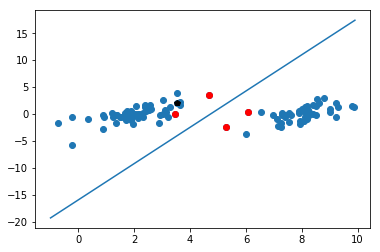

In [68]:
if __name__ == '__main__':
    filename = 'testSet.txt'
    dataArr, labelArr = loadData(filename)
    # b b是常量值 alphas是拉格朗日乘子
    b, alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40)
    print("\n\n\n")
    print('b:', b)
    print('alphas:', alphas)
    for i in range(100):
        if alphas[i] > 0:
            print(dataArr[i], labelArr[i])
            
    ws = calaWs(alphas, dataArr, labelArr)
    plotfig_SVM(dataArr, labelArr, ws, b, alphas)